# 03 - Modélisation

## Objectif
Créer et comparer 3 modèles:
- **Linear Regression** avec PolynomialFeatures + SequentialFeatureSelector + GridSearchCV
- **KNN** avec PolynomialFeatures + SequentialFeatureSelector + GridSearchCV  
- **Logistic Regression** avec PolynomialFeatures + GridSearchCV


## Comparaison
- Métriques : Accuracy, ROC AUC, MSE (pour régression)
- Visualisations : Courbes ROC, matrices de confusion
- Sauvegarde des modèles pour Streamlit

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, mean_squared_error, roc_curve)

# Modèles
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

# Configuration visualisation
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [13]:
# Chargement des données prétraitées
preprocessed_data = joblib.load('../data/processed/preprocessed_data.pkl')

# Extraire les données
X_train = preprocessed_data['X_train']
X_val = preprocessed_data['X_val']
X_test = preprocessed_data['X_test']
y_train = preprocessed_data['y_train']
y_val = preprocessed_data['y_val']
y_test = preprocessed_data['y_test']

# Récupérer les métadonnées
feature_names = preprocessed_data['feature_names']
preprocessor = preprocessed_data['preprocessor']

In [14]:
# 1. PIPELINE LINEAR REGRESSION
# Pipeline complet = MODÈLE 
linreg_pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('feature_selector', SequentialFeatureSelector(
        LinearRegression(), 
        n_features_to_select='auto', 
        direction='forward', 
        scoring='neg_mean_squared_error', 
        cv=3 )),
    ('linreg', LinearRegression())  # Modèle final
])

# Grille d'hyperparamètres
linreg_param_grid = {
    'poly__degree': [1, 2],  # Degré polynomial
    'feature_selector__n_features_to_select': [4]  # Nombre de features
}

# GridSearchCV avec validation croisée
linreg_grid = GridSearchCV(
    linreg_pipeline,
    linreg_param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entraînement
print("Recherche des meilleurs hyperparamètres...")
linreg_grid.fit(X_train, y_train)

# Meilleur modèle
linreg_model = linreg_grid.best_estimator_

print(f"\nMeilleurs paramètres Linear Regression:")
for param, value in linreg_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"Meilleur score CV (MSE négatif): {linreg_grid.best_score_:.4f}")
print(f"Pipeline Linear Regression optimisé = Modèle final")

Recherche des meilleurs hyperparamètres...
Fitting 3 folds for each of 2 candidates, totalling 6 fits



Meilleurs paramètres Linear Regression:
  feature_selector__n_features_to_select: 4
  poly__degree: 1
Meilleur score CV (MSE négatif): -0.0887
Pipeline Linear Regression optimisé = Modèle final


In [11]:
# 2. PIPELINE KNN - OPTIMISÉ POUR VITESSE
# Pipeline complet = MODÈLE (optimisé par GridSearchCV)
knn_pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # Features polynomiales
    ('feature_selector', SequentialFeatureSelector(
        KNeighborsClassifier(n_neighbors=5),  # Fixer n_neighbors pour SFS
        n_features_to_select=4,  # Fixer pour éviter 'auto' lent
        direction='forward',
        scoring='accuracy',
        cv=2  # Réduit de 3 à 2 pour vitesse
    )),
    ('knn', KNeighborsClassifier())  # Modèle final
])

# Grille d'hyperparamètres RÉDUITE pour vitesse
knn_param_grid = {
    'poly__degree': [1, 2],  # Garder les degrés polynomiaux
    'knn__n_neighbors': [5, 11],  # Réduit de [5, 11] - valeurs optimales
    'knn__weights': ['distance'],  # Meilleure performance, réduit de 2 à 1
    'knn__metric': ['euclidean']  # Réduit de 2 à 1 - plus rapide
}

# GridSearchCV avec validation croisée optimisée
knn_grid = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),  # Réduit de 3 à 2
    scoring='accuracy',
    n_jobs=-1,  # Parallélisation maximale
    verbose=1
)

# Entraînement
print("Recherche des meilleurs hyperparamètres KNN...")
knn_grid.fit(X_train, y_train)

# Meilleur modèle
knn_model = knn_grid.best_estimator_

print(f"\nMeilleurs paramètres KNN:")
for param, value in knn_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"Meilleur score CV: {knn_grid.best_score_:.4f}")
print(f"Pipeline KNN optimisé = Modèle final")
print(f"⚡ Optimisation: CV=2 folds, grille réduite, SFS avec CV=2")

Recherche des meilleurs hyperparamètres KNN...
Fitting 2 folds for each of 4 candidates, totalling 8 fits

Meilleurs paramètres KNN:
  knn__metric: euclidean
  knn__n_neighbors: 11
  knn__weights: distance
  poly__degree: 2
Meilleur score CV: 0.8979
Pipeline KNN optimisé = Modèle final
⚡ Optimisation: CV=2 folds, grille réduite, SFS avec CV=2


In [15]:
# 3. PIPELINE LOGISTIC REGRESSION - OPTIMISÉ POUR VITESSE
# Pipeline complet = MODÈLE (optimisé par GridSearchCV)
logreg_pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Grille d'hyperparamètres RÉDUITE pour vitesse
logreg_param_grid = {
    'poly__degree': [1, 2],  # Garder les degrés polynomiaux
    'logreg__penalty': ['l2'],  # Réduit de ['l1', 'l2'] à ['l2'] - plus stable
    'logreg__C': [0.1, 1.0],  # Réduit de [0.01, 0.1, 1.0, 10.0] à [0.1, 1.0]
    'logreg__solver': ['liblinear']  # Fixé pour éviter la recherche
}

# GridSearchCV avec validation croisée optimisée
logreg_grid = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),  # Réduit de 3 à 2
    scoring='accuracy',
    n_jobs=-1,  # Parallélisation maximale
    verbose=1
)

# Entraînement
print("Recherche des meilleurs hyperparamètres Logistic Regression...")
logreg_grid.fit(X_train, y_train)

# Meilleur modèle
logreg_model = logreg_grid.best_estimator_

print(f"\nMeilleurs paramètres Logistic Regression:")
for param, value in logreg_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"Meilleur score CV: {logreg_grid.best_score_:.4f}")
print(f"Pipeline Logistic Regression optimisé = Modèle final")
print(f"⚡ Optimisation: CV=2 folds, grille réduite, solver fixé")

Recherche des meilleurs hyperparamètres Logistic Regression...
Fitting 2 folds for each of 4 candidates, totalling 8 fits

Meilleurs paramètres Logistic Regression:
  logreg__C: 0.1
  logreg__penalty: l2
  logreg__solver: liblinear
  poly__degree: 1
Meilleur score CV: 0.9016
Pipeline Logistic Regression optimisé = Modèle final
⚡ Optimisation: CV=2 folds, grille réduite, solver fixé


In [17]:
# 4. ÉVALUATION COMPARATIVE DES 3 MODÈLES
# Fonction d'évaluation
def evaluate_model(model, X_test, y_test, model_name):
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Pour Linear Regression (régression), convertir les prédictions en classification binaire
    if 'Linear' in model_name or not hasattr(model, 'predict_proba'):
        # Convertir les prédictions continues en binaires (0 ou 1)
        y_pred_class = (y_pred > 0.5).astype(int)
        y_proba = y_pred  # Garder les valeurs continues pour ROC AUC
    else:
        # Pour les modèles de classification
        y_pred_class = y_pred
        y_proba = model.predict_proba(X_test)[:, 1]
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred_class)
    mse = mean_squared_error(y_test, y_pred_class)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"\nPerformance {model_name} sur test:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'mse': mse,
        'roc_auc': roc_auc,
        'y_pred': y_pred_class,
        'y_proba': y_proba
    }

# Évaluation des 3 modèles
results = []

results.append(evaluate_model(linreg_model, X_test, y_test, "Linear Regression"))
results.append(evaluate_model(knn_model, X_test, y_test, "KNN"))
results.append(evaluate_model(logreg_model, X_test, y_test, "Logistic Regression"))

# Création du DataFrame de résultats
results_df = pd.DataFrame([{
    'Modèle': r['model_name'],
    'Accuracy': r['accuracy'],
    'MSE': r['mse'],
    'ROC AUC': r['roc_auc']
} for r in results])

print("\nTABLEAU COMPARATIF FINAL:")
print(results_df.to_string(index=False))


Performance Linear Regression sur test:
  Accuracy: 0.9017
  MSE: 0.0983
  ROC AUC: 0.4895

Performance KNN sur test:
  Accuracy: 0.8807
  MSE: 0.1193
  ROC AUC: 0.4920

Performance Logistic Regression sur test:
  Accuracy: 0.9017
  MSE: 0.0983
  ROC AUC: 0.5084

TABLEAU COMPARATIF FINAL:
             Modèle  Accuracy      MSE  ROC AUC
  Linear Regression  0.901714 0.098286 0.489463
                KNN  0.880691 0.119309 0.492015
Logistic Regression  0.901714 0.098286 0.508350


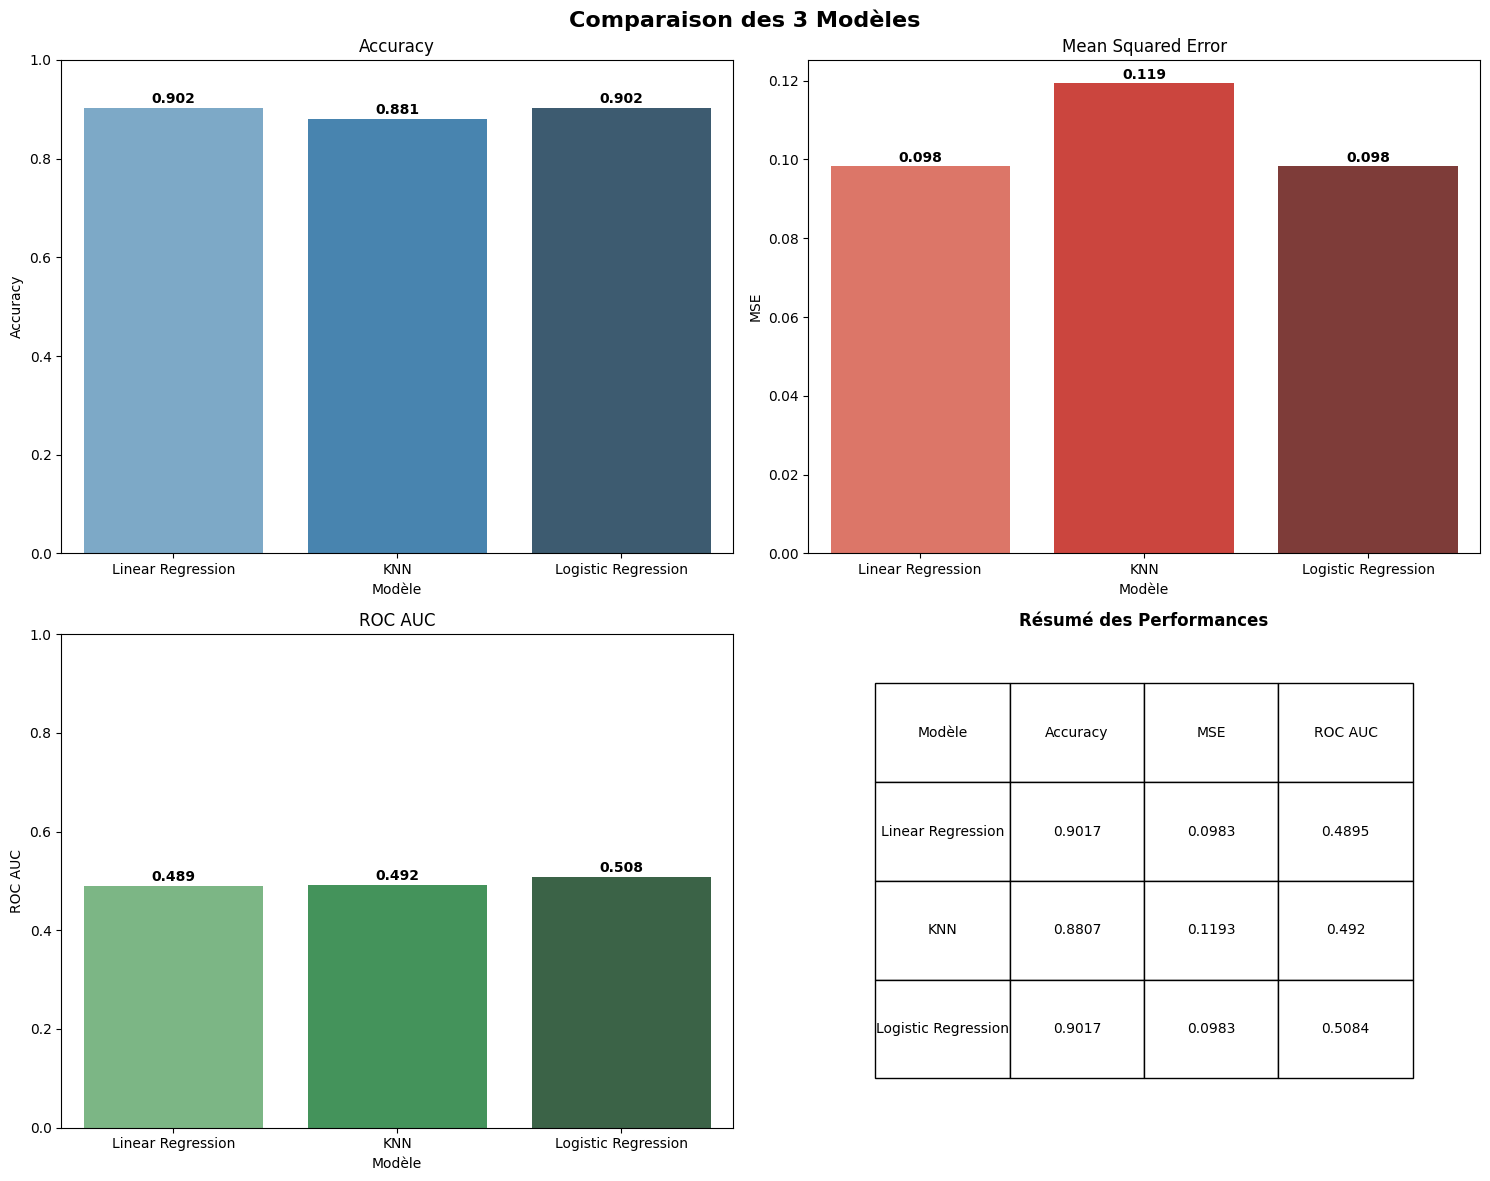

In [18]:
# 5. VISUALISATIONS COMPARATIVES
# Graphique comparatif des métriques
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparaison des 3 Modèles', fontsize=16, fontweight='bold')

# Accuracy
sns.barplot(data=results_df, x='Modèle', y='Accuracy', ax=axes[0,0], palette='Blues_d')
axes[0,0].set_title('Accuracy')
axes[0,0].set_ylim(0, 1)
for i, v in enumerate(results_df['Accuracy']):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# MSE
sns.barplot(data=results_df, x='Modèle', y='MSE', ax=axes[0,1], palette='Reds_d')
axes[0,1].set_title('Mean Squared Error')
for i, v in enumerate(results_df['MSE']):
    axes[0,1].text(i, v + 0.001, f'{v:.3f}', ha='center', fontweight='bold')

# ROC AUC
sns.barplot(data=results_df, x='Modèle', y='ROC AUC', ax=axes[1,0], palette='Greens_d')
axes[1,0].set_title('ROC AUC')
axes[1,0].set_ylim(0, 1)
for i, v in enumerate(results_df['ROC AUC']):
    axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Tableau récapitulatif
axes[1,1].axis('off')
table_data = results_df.round(4).values
table = axes[1,1].table(cellText=table_data,
                          colLabels=results_df.columns,
                          cellLoc='center',
                          loc='center',
                          bbox=[0.1, 0.1, 0.8, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1,1].set_title('Résumé des Performances', fontweight='bold')

plt.tight_layout()
plt.show()

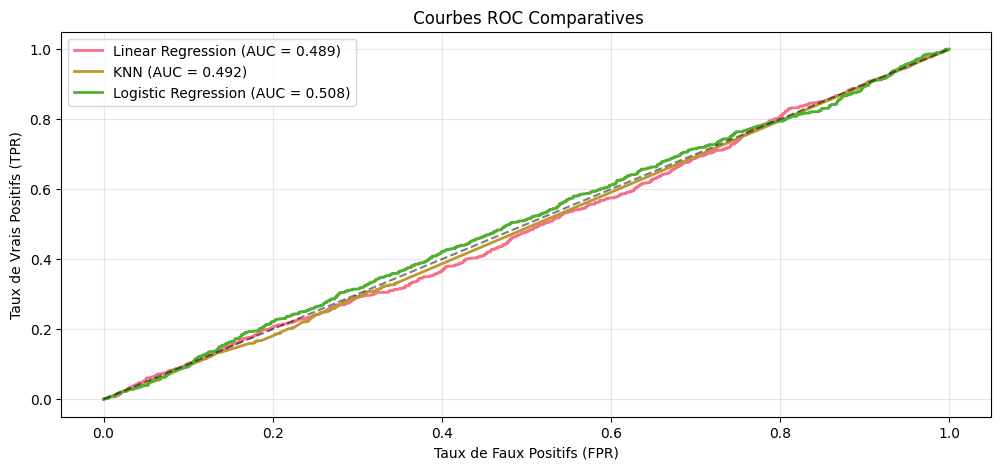

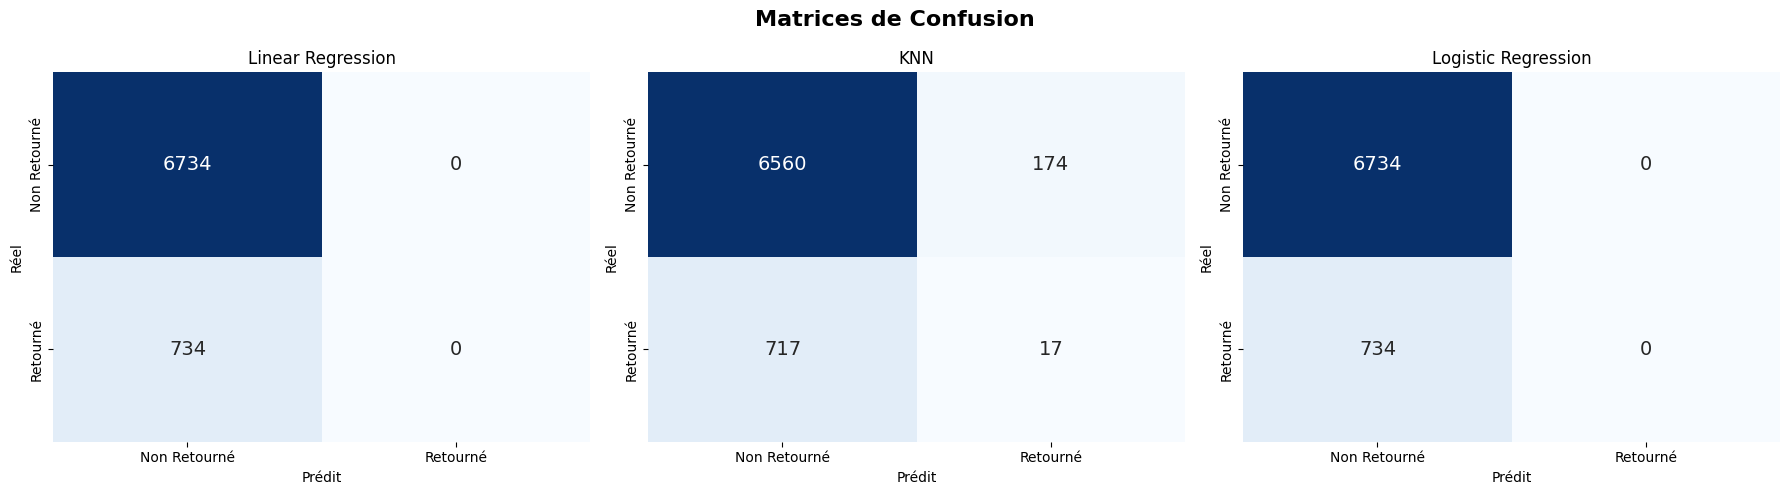

In [19]:
# 6. COURBES ROC ET MATRICES DE CONFUSION
# Courbes ROC
plt.figure(figsize=(12, 5))

# Courbe ROC pour chaque modèle
for result in results:
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    auc = result['roc_auc']
    plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {auc:.3f})", linewidth=2)

# Ligne diagonale
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title(' Courbes ROC Comparatives')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Matrices de confusion
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de Confusion', fontsize=16, fontweight='bold')

for idx, result in enumerate(results):
    cm = confusion_matrix(y_test, result['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=False, annot_kws={"size": 14})
    axes[idx].set_title(f'{result["model_name"]}')
    axes[idx].set_xlabel('Prédit')
    axes[idx].set_ylabel('Réel')
    
    # Ajouter les labels
    axes[idx].set_xticklabels(['Non Retourné', 'Retourné'])
    axes[idx].set_yticklabels(['Non Retourné', 'Retourné'])

plt.tight_layout()
plt.show()

In [21]:
# 7. ANALYSE DÉTAILLÉE DES RÉSULTATS
# Meilleur modèle selon chaque métrique
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
best_mse = results_df.loc[results_df['MSE'].idxmin()]
best_auc = results_df.loc[results_df['ROC AUC'].idxmax()]

print("\nMEILLEURS MODÈLES PAR MÉTRIQUE:")
print(f"Meilleure Accuracy: {best_accuracy['Modèle']} ({best_accuracy['Accuracy']:.4f})")
print(f"Plus petit MSE: {best_mse['Modèle']} ({best_mse['MSE']:.4f})")
print(f"Meilleur ROC AUC: {best_auc['Modèle']} ({best_auc['ROC AUC']:.4f})")

# Rapports de classification détaillés
print("\nRAPPORTS DE CLASSIFICATION DÉTAILLÉS:")
for result in results:
    print(f"\n{'='*50}")
    print(f"{result['model_name']}:")
    print(classification_report(y_test, result['y_pred'], 
                          target_names=['Non Retourné', 'Retourné']))

# Analyse des features sélectionnées (avec gestion des features polynomiales)
print("\nANALYSE DES FEATURES SÉLECTIONNÉES:")
for name, model in [("Linear Regression", linreg_model), 
                    ("KNN", knn_model), 
                    ("Logistic Regression", logreg_model)]:
    
    # Récupérer les features sélectionnées
    if hasattr(model, 'named_steps'):
        selector = model.named_steps.get('feature_selector')
        poly = model.named_steps.get('poly')
        
        if selector and hasattr(selector, 'get_support'):
            selected_features = selector.get_support()
            
            # Gérer les features polynomiales
            if poly and hasattr(poly, 'get_feature_names_out'):
                # Obtenir les noms des features polynomiales
                poly_feature_names = poly.get_feature_names_out(feature_names)
                selected_poly_features = [poly_feature_names[i] for i, selected in enumerate(selected_features) if selected]
                
                print(f"\n{name}: {len(selected_poly_features)} features sélectionnées")
                print(f"Features: {selected_poly_features[:5]}..." if len(selected_poly_features) > 5 else f"Features: {selected_poly_features}")
            else:
                # Si pas de PolynomialFeatures, utiliser les noms originaux
                feature_names_selected = [feature_names[i] for i, selected in enumerate(selected_features) if selected]
                print(f"\n{name}: {len(feature_names_selected)} features sélectionnées")
                print(f"Features: {feature_names_selected[:5]}..." if len(feature_names_selected) > 5 else f"Features: {feature_names_selected}")
        else:
            print(f"\n{name}: Pas de sélecteur de features trouvé")
    else:
        print(f"\n{name}: Pipeline non trouvé")


MEILLEURS MODÈLES PAR MÉTRIQUE:
Meilleure Accuracy: Linear Regression (0.9017)
Plus petit MSE: Linear Regression (0.0983)
Meilleur ROC AUC: Logistic Regression (0.5084)

RAPPORTS DE CLASSIFICATION DÉTAILLÉS:

Linear Regression:
              precision    recall  f1-score   support

Non Retourné       0.90      1.00      0.95      6734
    Retourné       0.00      0.00      0.00       734

    accuracy                           0.90      7468
   macro avg       0.45      0.50      0.47      7468
weighted avg       0.81      0.90      0.86      7468


KNN:
              precision    recall  f1-score   support

Non Retourné       0.90      0.97      0.94      6734
    Retourné       0.09      0.02      0.04       734

    accuracy                           0.88      7468
   macro avg       0.50      0.50      0.49      7468
weighted avg       0.82      0.88      0.85      7468


Logistic Regression:
              precision    recall  f1-score   support

Non Retourné       0.90      1.00 

In [22]:
# 8. SAUVEGARDE DES MODÈLES POUR STREAMLIT
# Dictionnaire des modèles
models_data = {
    'linreg_model': linreg_model,
    'knn_model': knn_model,
    'logreg_model': logreg_model,
    'results_df': results_df,
    'feature_names': feature_names,
    'preprocessor': preprocessor,
    'metadata': {
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'best_accuracy_model': best_accuracy['Modèle'],
        'best_auc_model': best_auc['Modèle'],
        'best_mse_model': best_mse['Modèle']
    }
}

# Sauvegarde
model_filename = '../data/processed/trained_models.pkl'
joblib.dump(models_data, model_filename)

# Résumé
print("\n" + "="*60)
print("RÉSUMÉ")
print("="*60)
print(f"Meilleure Accuracy: {best_accuracy['Modèle']} ({best_accuracy['Accuracy']:.4f})")
print(f"Meilleur MSE: {best_mse['Modèle']} ({best_mse['MSE']:.4f})")
print(f"Meilleur ROC AUC: {best_auc['Modèle']} ({best_auc['ROC AUC']:.4f})")
print(f"Modèles sauvegardés pour Streamlit")
print(f"Date: {models_data['metadata']['training_date']}")
print("="*60)


RÉSUMÉ
Meilleure Accuracy: Linear Regression (0.9017)
Meilleur MSE: Linear Regression (0.0983)
Meilleur ROC AUC: Logistic Regression (0.5084)
Modèles sauvegardés pour Streamlit
Date: 2026-02-16 14:35:32
